# ex4.NN Back Propagation(神经网络的反向传播)

这个练习再次处理手写数字数据集，这次使用反向传播的前馈神经网络，通过反向传播算法实现神经网络成本函数和梯度计算的非正则化和正则化版本，实现随机权重初始化和使用网络进行预测的方法。

In [3]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import  scipy.io as sio
from matplotlib import pyplot as plt
from scipy import optimize as opt
from sklearn.metrics import classification_report

## 获取数据

In [4]:
def get_data(file_path,transpose):
    data = sio.loadmat(file_path)
    X = data['X']
    y = data['y']
    if transpose:
        X = np.array([img.reshape(20,20).T for img in X])
        X = np.array([img.reshape(400) for img in X])
    return X,y

#one-hot编码
def one_hot(y):
    y_tmp = []
    for i in y:
        tmp = np.zeros(10)
        tmp[i-1] = 1
        y_tmp.append(tmp)
    y = np.array(y_tmp)
#    y = np.concatenate((np.array([y_tmp[:,-1]]).T,y_tmp[:,:-1]),axis = 1)
    return y

In [5]:
file_path = '/home/leedo/ML_Andrew_Ng/ML-exe/exe4-NN Learning/ex4data1.mat'
X , y = get_data(file_path,transpose =True)
print(X.shape,y.shape)
y_truth = y
X = np.insert(X,0,1,axis=1)
y = one_hot(y)
print(y.shape)

(5000, 400) (5000, 1)
(5000, 10)


## 数据可视化

In [6]:
def show_img(n,X):
    img_idx = np.random.choice(np.arange(5000),n*n)
    img = X[img_idx,:]
    fig,ax = plt.subplots(nrows=n,ncols=n,figsize =(10,10))
    for i in range(n):
        for j in range(n):
            ax[i,j].matshow(img[i*n+j].reshape(20,20),cmap=plt.cm.binary)
    plt.show

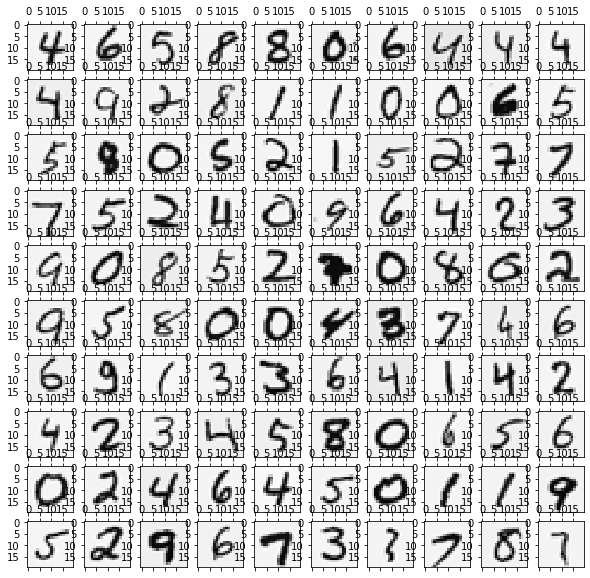

In [44]:
show_img(10,X)

## 模型表示
<img style="float: left;" src="../img/nn_model.png">

In [7]:
##加载权重
weight = sio.loadmat('/home/leedo/ML_Andrew_Ng/ML-exe/exe4-NN Learning/ex4weights.mat')
Theta1 = weight['Theta1']
Theta2 = weight['Theta2']
print(Theta1.shape)

def trans(a,b):
    
    m , n = a.shape[0] ,a.shape[1]
    j , k = b.shape[0] ,b.shape[1]
    
    res = np.concatenate((a.reshape(m*n),b.reshape(j*k)))
    return res

def detrans(a,input_size,K,hidden_size):
    
    a1 = a[:hidden_size*(input_size+1)].reshape(hidden_size,(input_size+1))
    a2 = a[hidden_size*(input_size+1):].reshape(K,hidden_size+1)
    
    return a1 , a2

theta = trans(Theta1,Theta2)


(25, 401)


## 前向传播和代价函数

<img style="float: left;" src="../img/nn_cost.png">

In [229]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def feedforward(X,Theta1,Theta2):
    a_1 = X

    z_2 = a_1 @ (Theta1.T)

    a_2 = np.insert(sigmoid(z_2),0,1,axis=1)
        
    z_3 = a_2 @ Theta2.T
    
    h = sigmoid(z_3)  
    return a_1,z_2,a_2,z_3,h
    
def cost(X,y,theta):

    theta1 ,theta2 = detrans(theta,input_size = 400,K=10,hidden_size=25)
    _,_,_,_,h = feedforward(X,theta1,theta2)
    inner = (-y)*np.log(h)-(1-y)*np.log(1-h)

    return np.sum(inner)/(len(X))

In [221]:
a_1,z_2,a_2,z_3,h = feedforward(X,Theta1,Theta2)
cost_data = cost(X,y,theta)
cost_data

5.830351257959722

## 正则化代价函数

<img style="float: left;" src="../img/nn_regcost.png">

In [251]:
def cost_reg(theta,X,y,lamb):

    theta1 ,theta2 = detrans(theta,input_size = 400,K=10,hidden_size=25)
    theta_cost = np.sum(pow(theta1[:,1:],2))+np.sum(pow(theta2[:,1:],2))
    
    return cost(X,y,theta) + lamb/(2*len(X))*theta_cost

# Backpropagation

## Sigmoid gradient


In [199]:
def sigmoid_gradient(x):
    return np.multiply(sigmoid(x),1-sigmoid(x))

## 随机初始化
在训练神经网络时，对参数进行随机初始化是很重要的。一种有效的随机初始化策略是在[−init，init]范围内均匀地随机选择θ的值，例中使用init = 0.12。这个范围的值确保参数保持小，使学习更有效。

In [200]:
def random_init(epsilon_init,size):
    return np.random.uniform(-epsilon_init,epsilon_init,size)

## 反向传播

In [201]:
def backpropagation(X,y,Theta1,Theta2):
    D_1 = np.zeros(Theta1.shape)
    D_2 = np.zeros(Theta2.shape)
    m = len(X)
    a_1,z_2,a_2,z_3,h = feedforward(X,Theta1,Theta2)
    z_2 = np.insert(z_2,0,1,axis=1)
    for i in range(m):
        
        delta3 = (h[i,:] - y[i,:]).reshape(1,10)
        delta2 = np.multiply(Theta2.T.dot(delta3.T),sigmoid_gradient(z_2[i,:]).reshape(26,1))
        D_2+=delta3.T.dot(a_2[i,:].reshape(1,26))
        D_1+=delta2[1:].dot(a_1[i,:].reshape(1,401))
    D_1 = D_1/m
    D_2 = D_2/m
    return D_1,D_2

In [284]:
D_1,D_2= backpropagation(X,y,Theta1,Theta2)

## 梯度校验

<img style="float: left;" src="../img/gradient_checking.png">

In [1]:
def gradient_check(X,y,theta):
    
    theta_mat = np.array([theta]*len(theta))
    print(theta.shape)
    
    l = len(theta_vec)
    epsilon = 0.0001
    epsilon_mat = np.identity(l)*epsilon
    add = theta + epsilon_mat
    minus = theta - epsilon_mat
    
    grad_check = np.zeors(l)
    for i in range(l):
        grad_check[i] = (add[i,:] - minus[i,:])/(2*epsilon)
        
    grad_compute = gradient_reg(theta,X,y,lamb=1)
    
    diff = np.linalg.norm(grad_compute-grad_check)/np.linalg.norm(grad_compute+grad_check)
    print("If your backpropagation implementation is correct,you should see a relative difference that is less than 1e-9.")
    if diff > pow(10,-9):
        print("Your relative difference is{},so backpropagation implementation is not correct, please check it".format(diff))
    else:
        print("Your relative difference is{},so backpropagation implementation is correct".format(diff))
    return grad_check



## 正则化神经网络

<img style="float: left;" src="../img/nn_reg_grad.png">

In [249]:
def gradient_reg(theta,X,y,lamb):
    theta1 ,theta2 = detrans(theta,input_size = 400,K=10,hidden_size=25)
    
    D_1,D_2 = backpropagation(X,y,theta1,theta2)
    
    theta1[:,0] = 0
    D_1 = D_1 + (lamb/len(X))*theta1
    
    theta2[:,0] = 0
    D_2 = D_2 + (lamb/len(X))*theta2
    
    return trans(D_1,D_2)

## Learning parameters 

In [240]:
#随机初始化theta
K = 10
init_theta = random_init(0.12,size = (10285))
init_theta.shape

(10285,)

In [263]:
def predict(init_theta,X,y,lamb):
    res = opt.minimize(fun = cost_reg,
                       x0 = init_theta,
                       args = (X, y, lamb),
                       method='TNC',
                       jac = gradient_reg,
                       options={'maxiter': 400})
    return res
## 注意代价函数和梯度计算函数的传参顺序

In [252]:
res = predict(init_theta,X,y,lamb=1)

In [253]:
res

     fun: 0.3157383668621824
     jac: array([-2.30850642e-04,  8.77655597e-08,  2.43737429e-07, ...,
       -2.89493055e-05, -5.68187639e-06, -3.58807113e-05])
 message: 'Max. number of function evaluations reached'
    nfev: 402
     nit: 25
  status: 3
 success: False
       x: array([ 5.32674561e-01,  4.38827799e-04,  1.21862852e-03, ...,
       -1.07375672e+00,  3.07810415e+00, -1.08338280e+00])

In [261]:
final_theta = res.x

## 准确率

In [262]:
theta1 , theta2 = detrans(final_theta,input_size = 400, K=10,hidden_size=25)
_,_,_,_,h = feedforward(X,theta1,theta2)
y_pre = np.argmax(h,axis=1)+1
print(classification_report(y_pre,y_truth))

              precision    recall  f1-score   support

           1       1.00      0.99      1.00       504
           2       1.00      1.00      1.00       500
           3       0.99      1.00      0.99       496
           4       1.00      0.99      1.00       501
           5       1.00      1.00      1.00       499
           6       1.00      1.00      1.00       501
           7       0.99      0.99      0.99       499
           8       1.00      1.00      1.00       501
           9       0.99      0.99      0.99       499
          10       1.00      1.00      1.00       500

    accuracy                           1.00      5000
   macro avg       1.00      1.00      1.00      5000
weighted avg       1.00      1.00      1.00      5000



# 可视化隐藏层

In [282]:
def show_hidden_layer(theta):
    hidden_layer = theta[:,1:]
    fig, ax = plt.subplots(nrows = 5, ncols = 5, sharey=True, sharex=True, figsize=(5,5))
    
    for i in range(5):
        for j in range(5):
            ax[i,j].matshow(hidden_layer[5*i+j].reshape((20,20)))#cmap=plt.cm.binary
    plt.show()

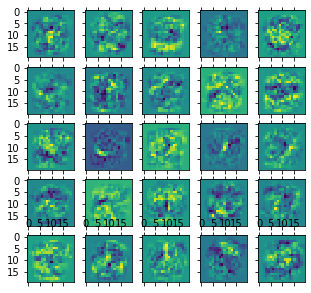

In [283]:
show_hidden_layer(theta1)